# 🦒 Running Deep Learning Models with BioEngine ⚙️☁️

Welcome to this tutorial! We'll guide you through running image analysis models from [BioImage.IO](https://bioimage.io) using the BioEngine server.

We'll show you how to:
1. Load an image,
2. Reshape it according to each model's specifications (called `RDF` – a metadata format describing the models hosted on [BioImage.IO](https://bioimage.io)),
3. Send the image (as a numpy array) to the BioEngine server to run the models. 🚀

All models showcased are available in the [BioImage.IO Model Zoo](https://bioimage.io/#). You can also adapt this tutorial for other models in the zoo! 🧑‍🔬

⚠️ **Note:** The data will be sent to a remote server ([https://hypha.aicell.io](https://hypha.aicell.io)) run by the AI4Life team. This service is for evaluation purposes only and may change without notice. If you're looking for an on-prem solution (HPC or Kubernetes), check out the deployment guidelines here: [BioEngine Worker](https://github.com/aicell-lab/bioengine-worker/tree/bioengine-worker?tab=readme-ov-file#bioengine-worker).

If you're using your own instance, be sure to update the server URL (`https://hypha.aicell.io`) and the BioEngine service ID (`bioimage-io/model-runner`) accordingly. 🔧

## Installation and module imports

In [ ]:
try:
    # For pyodide in the browser
    import micropip

    await micropip.install(["pyodide-http", "hypha-rpc", "kaibu-utils", "matplotlib"])

    # 2. Patch requests
    import pyodide_http

    pyodide_http.patch_all()  # Patch all libraries
except ImportError:
    # For native python with pip
    import subprocess

    subprocess.call(["pip", "install", "hypha-rpc", "kaibu-utils", "matplotlib"])

import asyncio
import json
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import requests
from hypha_rpc import connect_to_server, login

Server URL: We will use the public hypha.aicell.io server

Model ID: The Model-Runner will be demonstrated with the "ambitious-ant" model

In [2]:
SERVER_URL = "https://hypha.aicell.io"

MODEL_ID = "ambitious-ant"

### Connect to the server

In [3]:
token = await login({"server_url": SERVER_URL})
server = await connect_to_server(
    {"server_url": SERVER_URL, "token": token, "method_timeout": 3000}
)

Please open your browser and login at https://hypha.aicell.io/public/apps/hypha-login/?key=3P4sZMSsH2vcbzU23W9xJA


### Access the BioEngine deployments

A public BioEngine Model-Runner application is available with the service ID `bioimage-io/model-runner`

In [4]:
PUBLIC_MODEL_RUNNER_SERVICE_ID = "bioimage-io/model-runner"

model_runner = await server.get_service(PUBLIC_MODEL_RUNNER_SERVICE_ID)

#### Start your own BioEngine Model-Runner (Optional)
*(Skip this step if you only want to run the Model-Runner application in the public Model-Runner service)*

To start your own Model-Runner application, you first need to have a running BioEngine worker. If you don't have one, you can follow the [BioEngine Worker deployment guide](https://bioimage.io/#/bioengine) to set up your own BioEngine worker.

Let's check for running BioEngine workers in your workspace:

In [ ]:
services = await server.list_services({"type": "bioengine-worker"})

for i, service in enumerate(services):
    if i == 0:
        print("✅ BioEngine worker services available in your workspace:\n")
    if i == len(services) - 1:
        print(" * ", end="")
        PRIVATE_BIOENGINE = service.id
    else:
        print("   ", end="")
    print(f"BioEngine worker service ID: {service.id}")

if len(services) == 0:
    print(
        f"⚠️  No BioEngine worker service available in workspace '{server.config.workspace}'."
    )
else:
    bioengine_worker = await server.get_service(PRIVATE_BIOENGINE)

✅ BioEngine worker services available in your workspace:

 * BioEngine worker service ID: ws-user-github|49943582/o589VKXu6WvqMQBRSnEmkX:bioengine-worker


Run the following code to start the Model-Runner application on your BioEngine worker. If you don't have a GPU available, set `disable_gpu=True`.

The deployment progress can be monitored using the BioEngine worker status. We wait until the Model-Runner application is ready before proceeding. Depending on your internet connection and hardware, this may take a few minutes. Once the Model-Runner application is ready, you can get the service ID of the Model-Runner application and connect to it.

In [ ]:
app_id = await bioengine_worker.deploy_application(
    artifact_id="bioimage-io/model-runner",
    application_id="model-runner",
    disable_gpu=False,
)
print(f"🔄 Started Model-Runner application with ID: '{app_id}'")

status = None
iterations = 0
while status != "RUNNING":
    await asyncio.sleep(1)
    worker_status = await bioengine_worker.get_status()
    model_runner_status = worker_status["bioengine_apps"][app_id]
    status = model_runner_status["status"]
    if status == "RUNNING":
        print("✅ Model-Runner is ready to use!", " " * 20)
        private_model_runner_service_id = model_runner_status["service_ids"][0][
            "websocket_service_id"
        ]
        model_runner = await server.get_service(private_model_runner_service_id)
    else:
        waiting_dots = "." * iterations + " " * (5 - iterations)
        print(
            f"⚠️ Model-Runner is currently {model_runner_status['status']}. Waiting{waiting_dots}",
            end="\r",
        )
        iterations += 1
        if iterations > 5:
            iterations = 0

🔄 Started Model-Runner application with ID: 'model-runner'
✅ Model-Runner is ready to use!                     


### View the RDF

The RDF is a JSON object that describes the model's inputs, outputs, and other metadata. You can view the RDF of the model by running the following code:

In [5]:
model_rdf = await model_runner.get_model_rdf(model_id=MODEL_ID)

print(json.dumps(model_rdf, indent=4))

{
    "authors": [
        {
            "affiliation": "Fudan University",
            "name": "Chenxi Ma"
        },
        {
            "affiliation": "Fudan University",
            "name": "Weimin Tan"
        },
        {
            "affiliation": "Fudan University",
            "name": "Ruian He"
        },
        {
            "affiliation": "Fudan University",
            "name": "Bo Yan"
        }
    ],
    "cite": [
        {
            "doi": "10.21203/rs.3.rs-3208267/v1",
            "text": "Chenxi Ma, Weimin Tan, Ruian He and Bo Yan. Pre-training a Foundation Model for Universal Fluorescence Microscopy Image Restoration. (2023)."
        }
    ],
    "config": {
        "bioimageio": {
            "nickname": "ambitious-ant",
            "nickname_icon": "\ud83d\udc1c",
            "thumbnails": {
                "cover1.png": "cover1.thumbnail.png",
                "cover2.png": "cover2.thumbnail.png"
            }
        }
    },
    "covers": [
        "cover1.

### Download an example image

In this notebook, we will use the example image provided with the model. If you want to use your own image, you can skip this step and load your image directly.

In [6]:
if "test_tensor" in model_rdf["inputs"][0]:
    example_input_source = model_rdf["inputs"][0]["test_tensor"]["source"]
elif "test_inputs" in model_rdf:
    example_input_source = model_rdf["test_inputs"][0]
else:
    raise RuntimeError("❌ No example input tensor found in model RDF.")

example_input_url = f"https://hypha.aicell.io/bioimage-io/artifacts/{MODEL_ID}/files/{example_input_source}"
response = requests.get(example_input_url)

# Ensure the request was successful
response.raise_for_status()

# Load the image data from the response content
image = np.load(BytesIO(response.content))
print(f"Example image downloaded: {image.shape}")

Example image downloaded: (1, 1, 128, 128)


Before passing the image to the model, you need to make sure it has the correct shape. The RDF provides information about the expected input shape, including the number of dimensions and axis names.

In [7]:
axes = model_rdf["inputs"][0]["axes"]

n_dim = len(axes)

axis_names = []
for axis in axes:
    if isinstance(axes, str):
        axis_names.append(axis)
    elif "id" in axis:
        axis_names.append(axis["id"])
    elif "type" in axis:
        axis_names.append(axis["type"])
    else:
        axis_names.append("<undefined>")

print(f"Expected model input: ({', '.join(axis_names)})")

Expected model input: (b, c, y, x)


Let's visualize the example image provided with the model and validate that the axis names match the expected input shape.

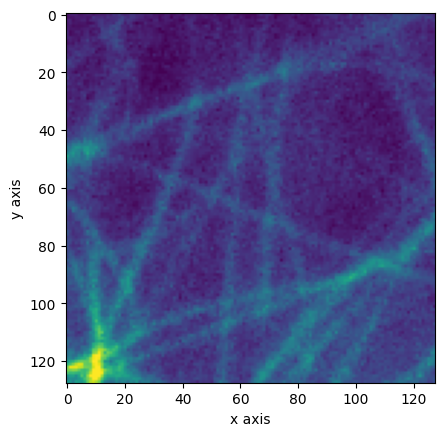

In [8]:
# Display the image using matplotlib
# Find the indices for x and y axes
display_slice = []
y_label = None
x_label = None
for axis_name in axis_names:
    if axis_name == "x" or axis_name == "y":
        display_slice.append(slice(None))  # Use full slice for x and y axes
        if y_label is None:
            y_label = f"{axis_name} axis"
        elif x_label is None:
            x_label = f"{axis_name} axis"
    else:
        display_slice.append(0)  # Use index 0 for other axes
display_slice = tuple(display_slice)

plt.imshow(image[display_slice])
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

Since we are using the example image, it already has the correct shape. If you want to use your own image, make sure to reshape it according to the model's input shape specified in the RDF.

## Make a prediction with the Model-Runner

In [9]:
result = await model_runner.infer(model_id=MODEL_ID, inputs=image)

if "id" in model_rdf["outputs"][0]:
    output_key = model_rdf["outputs"][0]["id"]
elif "name" in model_rdf["outputs"][0]:
    output_key = model_rdf["outputs"][0]["name"]
else:
    raise RuntimeError("❌ No output key found in model RDF.")
mask = result[output_key]
print("prediction:", mask.shape)

prediction: (1, 1, 256, 256)


## Display the segmentation result

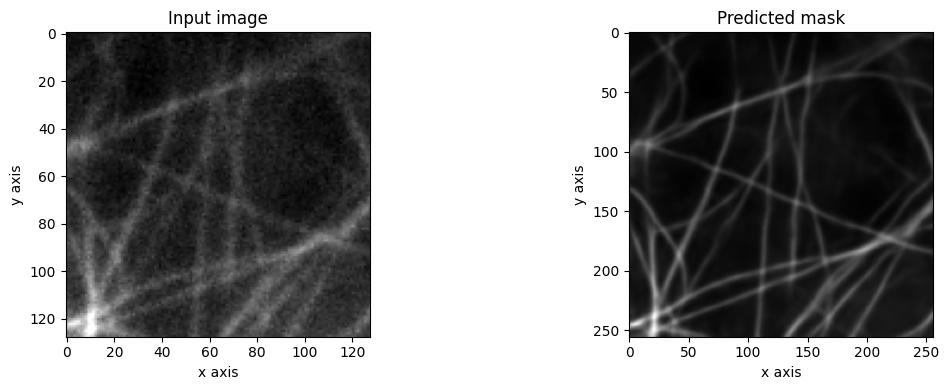

In [10]:
# display the output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Find the indices for x and y axes
try:
    # Display input image using dynamic axis selection
    input_display = image[display_slice]
    ax1.imshow(input_display, cmap="gray")
    ax1.set_title("Input image")
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)

    # Display predicted mask using dynamic axis selection
    mask_display = mask[display_slice]
    ax2.imshow(mask_display, cmap="gray")
    ax2.set_title("Predicted mask")
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)

except ValueError:
    # Fallback to original method if x and y axes not found
    print("Warning: 'x' and 'y' axes not found in model RDF, using default display")

    # Display input image - squeeze to remove batch and channel dimensions for display
    input_display = image[0, 0, :, :]  # Remove batch and channel dims
    ax1.imshow(input_display, cmap="gray")
    ax1.set_title("Input image")

    # Display predicted mask - squeeze to remove batch and channel dimensions
    mask_display = mask[0, 0, :, :]  # Remove batch and channel dims
    ax2.imshow(mask_display, cmap="gray")
    ax2.set_title("Predicted mask")

plt.tight_layout()
plt.show()

## Trying more models in BioImage.IO

Feel free to find more models at https://bioimage.io. If you want to run a model, please do the following as shown above:
 - Copy the animal nickname id in the model card
 - Print the RDF information so you know what's the expected input shape
 - Load your image, and make sure you reshape or resize it according to the expected input shape using numpy or scikit-image etc.
 - Run the model via `model_runner.infer()`, by passing the model id and image
 - Get the result, extract the image for display according to the output shape according to the RDF.


## Hosting your own BioEngine

While the above demo uses our public free BioEngine server, you can also launch your own bioengine server on a GPU workstation or HPC, and connect to your own BioEngine instance by switching the server URL. If you are interested please follow the deployment guidelines here: [BioEngine Worker](https://github.com/aicell-lab/bioengine-worker/tree/bioengine-worker?tab=readme-ov-file#bioengine-worker).

If you're using your own instance, be sure to update the server URL (`https://hypha.aicell.io`) and the BioEngine service ID (`bioimage-io/model-runner`) accordingly. 🔧

Please note that the deployment is in early stage, so if you have any issues or trouble setting it up, please don't hesitate to reach out via email, forum, web form or GitHub issues: https://github.com/aicell-lab/bioengine-worker/issues